In [1]:
from skimage.io import imread
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
os.listdir('/Users/qihou/HAM10000_train')

['akiec', '.DS_Store', 'df', 'bkl', 'vasc', 'nv', 'bcc', 'mel']

In [3]:
os.listdir('/Users/qihou/HAM10000_test')

['akiec', '.DS_Store', 'df', 'bkl', 'vasc', 'nv', 'bcc', 'mel']

In [4]:
train_dir = '/Users/qihou/HAM10000_train'
test_dir = '/Users/qihou/HAM10000_test'

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
train_datagen = ImageDataGenerator(rescale = 1/255) 
test_datagen = ImageDataGenerator(rescale = 1/255)

train_gen = train_datagen.flow_from_directory(train_dir, batch_size=6)
test_gen = test_datagen.flow_from_directory(test_dir, batch_size=6)

Found 8012 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.


In [7]:
x, y = next(train_gen)
x.shape, y.shape

((6, 256, 256, 3), (6, 7))

In [8]:
train_gen.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [9]:
df = pd.read_csv('/Users/qihou/HAM10000_metadata.csv')

In [10]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Calculate Class Weights

In [11]:
from sklearn.utils import class_weight
import numpy as np

In [12]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_gen.classes), 
                train_gen.classes)

In [13]:
class_weights

array([ 4.43632337,  2.71869698,  1.3140889 , 13.15599343,  1.29038493,
        0.21326093,  9.459268  ])

## Define Model

In [14]:
#import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input, Dropout
from tensorflow.keras.layers import BatchNormalization

In [31]:
pool_size = (4,4)
kernel_size = (3,3)

x_in = Input(shape = (256, 256, 3))

x = Conv2D(filters = 16, kernel_size = kernel_size, activation = 'relu', padding = 'Same')(x_in)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = pool_size)(x)

x = Conv2D(filters = 32, kernel_size = kernel_size, activation = 'relu', padding = 'Same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = pool_size)(x)

x = Conv2D(filters = 64, kernel_size = kernel_size, activation = 'relu', padding = 'Same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = pool_size)(x)

x_flatten = Flatten()(x)
x = Dropout(0.5)(x_flatten)
x = Dense(64, activation = 'relu')(x)

x_out = Dense(7, activation= 'softmax')(x) 

In [32]:
model = Model(x_in, x_out)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
batch_normalization_9 (Batch (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
batch_normalization_10 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0   

In [33]:
model.compile(optimizer ='adam',
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

In [ ]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch = len(train_gen),
    epochs = 100,
    validation_data = test_gen,
    validation_steps = len(test_gen),
    workers=4,
    class_weight = class_weights
)

Epoch 1/100
 401/1336 [========>.....................] - ETA: 2:36 - loss: 0.7632 - acc: 0.7244

In [20]:
loss, acc = model.evaluate_generator(test_gen)

In [21]:
loss_train, acc_train = model.evaluate_generator(train_gen)

In [22]:
loss_train, acc_train

(0.40451867802906505, 0.8614578)

In [24]:
loss, acc

(0.6341577698086238, 0.77284074)

In [75]:
x, y = next(test_gen)
x.shape, y.shape

((6, 256, 256, 3), (6, 7))

In [76]:
y = model.predict(x)

In [80]:
y[4]

array([6.7488679e-07, 3.7248301e-05, 1.1395289e-05, 2.0914246e-08,
       8.9789595e-05, 9.9983919e-01, 2.1721995e-05], dtype=float32)

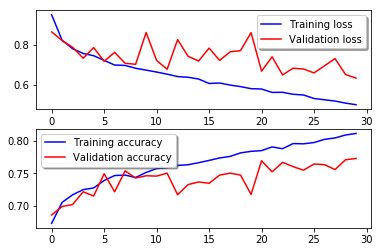

In [25]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='upper left', shadow=True)